In [1]:

#@title **Location** of the dataset
path =  "../data/LendingClub/"
process_path = "../data/ProcessedData/"
save_path = "../tests/"
ri_datasets_path = "../data/riData/"
backup_image_folder = "../../backup/Images/"


In [2]:
import argparse
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import secrets
import joblib
import os
import re
import logging



from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from lightgbm import LGBMClassifier
from pathlib import Path
from sklearn.metrics import (roc_auc_score)
from sklearn.model_selection import KFold
from sklearn.impute import KNNImputer
from sklearn.feature_selection import r_regression


 
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                            f1_score, precision_score, recall_score,
                            roc_auc_score, roc_curve)

 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.semi_supervised import LabelSpreading

 
import credit_pipeline.data_exploration as dex
import credit_pipeline.training as tr
import credit_pipeline.reject_inference as ri
import credit_pipeline.evaluate as ev

from submodules.topsis_python import topsis as top


In [3]:
#ARGs and constants
parser = argparse.ArgumentParser(description='Simple Script')
parser.add_argument('-ar', '--ar_range', type=int, nargs=2, default=[0, 100], help='Low and High AR value', metavar=('LOW_AR', 'HIGH_AR'))
parser.add_argument('-wt', '--weights', type=int, nargs=2, default=[1, 1], help='weights of metrics for Topsis', metavar=('Weight_AUC, Weight_Kickout'))
parser.add_argument('--seed', type=int, default=388389, help='Seed number')
parser.add_argument('-y', '--year', type=int, default=2010, help='Year')
parser.add_argument('-p', '--percent_bad', type=float, default=0.2, help='Percentage bad added')
parser.add_argument('-ut', '--use_test', action='store_true', default=True, help='Use test set to evaluate')
parser.add_argument('-tri', '--train_ri', action='store_true', default=True, help='Train others RI models')
parser.add_argument('-re', '--reuse_exec', action='store_true', default=False, help='Reuse trained models')
parser.add_argument('-tn', '--train_tn', action='store_true', default=True, help='Train Trusted Non-Outliers models')
args = parser.parse_args({})


#Accept rate
if args.ar_range:
    low_AR, high_AR = args.ar_range

#Weights
if args.weights:
    Weight_AUC, Weight_Kickout = args.weights

#TopSis
weights = [Weight_AUC, Weight_Kickout]
criterias = np.array([True, True])


#Set seed
if args.seed:
    seed_number = args.seed
else:
    seed_number = secrets.randbelow(1_000_000)
    while seed_number <100:
        seed_number = secrets.randbelow(1_000_000)
print(seed_number)
main_seed = seed_number

year = args.year 
metadata = {'seed': str(main_seed), 'year': str(args.year), 'p': str(args.percent_bad)}

388389


In [4]:
logpath = Path(os.path.join(ri_datasets_path,f'LC_py/log_{main_seed}'))
logpath.parent.mkdir(parents=True, exist_ok=True)

logging.getLogger().handlers = []
logging.basicConfig(filename=logpath, 
                    filemode='a',  
                    level=logging.WARNING,  # This sets the threshold for the root logger
                    format='%(asctime)s - %(levelname)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S')

# Create and configure a custom logger for detailed (DEBUG level) logging
detailed_logger = logging.getLogger('detailed')
detailed_logger.setLevel(logging.DEBUG)  # Set this logger to capture everything

# Create a file handler for the custom logger (optional if you want all logs in the same file)
file_handler = logging.FileHandler(logpath)
file_handler.setLevel(logging.DEBUG)

# You might want to use the same formatter for consistency
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s', datefmt='%Y-%m-%d %H:%M:%S')
file_handler.setFormatter(formatter)

# Add the file handler to the detailed logger
detailed_logger.addHandler(file_handler)

detailed_logger.debug(logpath)

detailed_logger.debug(metadata)

detailed_logger.debug(args)

In [5]:
#Read Dataset
    
#Accepts

load_path = f'{ri_datasets_path}Load/{main_seed}_{args.year}'

if Path(f'{load_path}').exists() and False:
    df_train = pd.read_csv(f'{load_path}/A_train.csv', index_col=0)
    df_val = pd.read_csv(f'{load_path}/A_val.csv', index_col=0)
    df_test = pd.read_csv(f'{load_path}/A_test.csv', index_col=0)
    R_train = pd.read_csv(f'{load_path}/R_train.csv', index_col=0)
    R_val = pd.read_csv(f'{load_path}/R_val.csv', index_col=0)
    R_test = pd.read_csv(f'{load_path}/R_test.csv', index_col=0)
    X_train = df_train.loc[:, df_train.columns != "target"]
    y_train = df_train["target"]
    X_val = df_val.loc[:, df_val.columns != "target"]
    y_val = df_val["target"]
    X_test = df_test.loc[:, df_test.columns != "target"]
    y_test = df_test["target"]

    detailed_logger.debug(f'Data loaded from {load_path}')

else:
    detailed_logger.debug(f'Data not found in {load_path}')
    la = ["issue_d", "loan_amnt", "funded_amnt", "funded_amnt_inv", "term", "int_rate"]
    lb = ["installment", "emp_length", "annual_inc", "verification_status", "loan_status", 
        "purpose", "addr_state", "dti", "delinq_2yrs"]
    lc = ["inq_last_6mths", "open_acc", "home_ownership", "revol_bal", "revol_util",
        "total_acc", "total_pymnt", "total_rec_prncp", "total_rec_int", "total_pymnt_inv",
            "last_pymnt_amnt", "last_fico_range_high", "last_fico_range_low"]

    selected_columns_a = la+lb+lc
    # Define the chunk size for reading the CSV file
    chunksize = 100000  # Adjust this value based on your requirements
    # Initialize an empty list to store filtered chunks
    filtered_chunks = []
    # Read the CSV file in chunks based on the defined chunk size
    for chunk in pd.read_csv(path+'accepted_2007_to_2018Q4.csv', chunksize=chunksize, usecols=selected_columns_a):
        # Filter the current chunk based on the criteria
        filtered_chunk = chunk[chunk['issue_d'].str.contains(str(args.year), na=False)]
        detailed_logger.debug(f'Filtered chunk with shape: {filtered_chunk.shape}')
        # Append the filtered chunk to the list
        filtered_chunks.append(filtered_chunk)
    # Concatenate all filtered chunks into a single DataFrame
    df_a = pd.concat(filtered_chunks)

    detailed_logger.debug(f'Accepts read with shape: {df_a.shape}')
    # Now filtered_df contains only the rows that match the specified criteria
    detailed_logger.debug(f'Selected columns: {selected_columns_a}')
        
    #Rejects
    selected_columns_r = ["Application Date", "Debt-To-Income Ratio","State", "Risk_Score", "Amount Requested", "Employment Length"]
    # Define the chunk size for reading the CSV file
    chunksize = 100000  # Adjust this value based on your requirements
    # Initialize an empty list to store filtered chunks
    filtered_chunks = []
    # Read the CSV file in chunks based on the defined chunk size
    for chunk in pd.read_csv(path+'rejected_2007_to_2018Q4.csv', chunksize=chunksize, usecols=selected_columns_r):
        # Filter the current chunk based on the criteria
        chunk["Application Date"] = chunk["Application Date"].astype(str)
        filtered_chunk = chunk[chunk["Application Date"].str.contains(str(args.year), na=False)]
        # filtered_chunk = filtered_chunk[~filtered_chunk["Application Date"].str.contains("2013-10|2013-11|2013-12", na=False)]
        # Append the filtered chunk to the list
        filtered_chunks.append(filtered_chunk)
    # Concatenate all filtered chunks into a single DataFrame
    df_r = pd.concat(filtered_chunks)
    # Now filtered_df contains only the rows that match the specified criteria
    detailed_logger.debug(f'Rejects read with shape: {df_r.shape}')
    # Log the rejected columns
    detailed_logger.debug(f'Rejected columns: {df_r.columns.tolist()}')
        
    #rejected fix names
    df_r["emp_length"] = df_r["Employment Length"]
    df_r["addr_state"] = df_r["State"]
    df_r["dti"] = df_r["Debt-To-Income Ratio"]
    df_r["dti"] = pd.to_numeric(df_r['dti'].str.replace('%', ''))
    df_r["loan_amnt"] = df_r["Amount Requested"]
    df_r["risk_score"] = df_r["Risk_Score"]
    df_r["issue_d"] = df_r["Application Date"]

    #accepted fix names
    df_a["risk_score"] = df_a.loc[:,["last_fico_range_high","last_fico_range_low"]].mean(axis=1)
    df_a["target"] = np.where((df_a.loan_status == 'Current') |
                            (df_a.loan_status == 'Fully Paid') |
                            (df_a.loan_status== "Issued") |
                            (df_a.loan_status == 'Does not meet the credit policy. Status:Fully Paid'), 0, 1)


        
    for c in ["Amount Requested", "Employment Length", "State",
                    "Debt-To-Income Ratio", "Amount Requested","Risk_Score", "Application Date"]:
        try:
            df_r = df_r.drop(c, axis = 1)
        except Exception as e:
            detailed_logger.debug(e)
    for c in ['last_fico_range_high', 'last_fico_range_low', 'loan_status']:
        try:
            df_a = df_a.drop(c, axis = 1)
        except Exception as e:
            detailed_logger.debug(e)


    # columns based on Shih et al. (2022)
    r_cols = df_r.columns.to_list()
    pearson_a = ['int_rate', 'dti', 'delinq_2yrs', 'emp_length', 'annual_inc', 'inq_last_6mths', 'term',
    'home_ownership','revol_util', 'risk_score', 'target', 'issue_d']
    union_list = r_cols.copy()
    for item in pearson_a:
        if item not in union_list:
            union_list.append(item)
    # Now union_list contains all elements from r_cols first, followed by those unique to pearson_a
    df_a = df_a.loc[:, union_list]
            
    detailed_logger.debug("Now union_list contains all elements from r_cols first, followed by those unique to pearson_a")

        
    #Fix dtype of variable emp_length (Object -> number)
    try:
        df_a['emp_length'] = df_a['emp_length'].map(lambda x: "0" if x == '< 1 year' else x)
        df_a['emp_length'] = df_a['emp_length'].map(lambda x : int(re.search(r'\d+', x).group()), na_action='ignore')

        df_r['emp_length'] = df_r['emp_length'].map(lambda x: "0" if x == '< 1 year' else x)
        df_r['emp_length'] = df_r['emp_length'].map(lambda x : int(re.search(r'\d+', x).group()), na_action='ignore')
    except Exception as e:
        detailed_logger.debug(e)
    try:
        df_a['term'] = df_a['term'].map(lambda x : int(re.search(r'\d+', x).group()))
    except Exception as e:
        detailed_logger.debug(e)

        
    #add missing columns to df_r
    input_columns = df_a.columns.difference(df_r.columns).to_list()
    input_columns.remove('target')

    for col in input_columns:
        df_r.insert(df_r.columns.shape[0], col, np.nan)

    detailed_logger.debug('Data preprocessing complete!')


    # Split the data into training and testing sets
    try:
        train_rej = df_r[~df_r['issue_d'].str.contains(f"{args.year}-10|{args.year}-11|{args.year}-12", na=False)]
        train_acp = df_a[~df_a['issue_d'].str.contains(f"Oct-{args.year}|Nov-{args.year}|Dec-{args.year}", na=False)]

        test_rej = df_r[df_r['issue_d'].str.contains(f"{args.year}-10|{args.year}-11|{args.year}-12", na=False)]
        test_acp = df_a[df_a['issue_d'].str.contains(f"Oct-{args.year}|Nov-{args.year}|Dec-{args.year}", na=False)]
    except Exception as e:
        detailed_logger.debug(e)

    train_r, train_a, test_r, test_a = train_rej.copy(), train_acp.copy(), test_rej.copy(), test_acp.copy()

    for df in [train_r, train_a, test_r, test_a]:
        try:
            df.drop('issue_d', axis = 1, inplace=True)
            # df.drop('addr_state', axis = 1, inplace=True)
        except Exception as e:
            detailed_logger.debug(e)

    detailed_logger.debug(f'Train-Test split done')

        
    X_train = train_a.loc[:, ~train_a.columns.isin(["target","addr_state"])]
    y = train_a["target"]
    X_test = test_a.loc[:, test_a.columns != "target"]
    y_test = test_a["target"]


    knn_inputer = tr.create_pipeline(X_train,y, None, do_EBE=True, crit = 0, do_KNN=True)
    knn_inputer.fit(X_train,y)
    X_train_knn = knn_inputer[:-3].transform(X_train)
    X_test = knn_inputer[:-3].transform(X_test)
    R_train_knn = knn_inputer[:-3].transform(train_r.loc[:, train_r.columns != "addr_state"])
    R_test = knn_inputer[:-3].transform(test_r.loc[:, test_r.columns != "addr_state"])
    detailed_logger.debug(f'KNN input done')

    X_train, X_val, y_train, y_val = train_test_split(
        X_train_knn, y, test_size=0.3, random_state=main_seed, shuffle=True)
    R_train, R_val = train_test_split(
        R_train_knn, test_size=0.3, random_state=main_seed, shuffle=True)
    detailed_logger.debug(f'Train-Val split done')

    os.makedirs(f'{load_path}', exist_ok=True)
    pd.concat([X_train, y_train], axis=1).to_csv(f'{load_path}/A_train.csv', index=True)
    pd.concat([X_val, y_val], axis=1).to_csv(f'{load_path}/A_val.csv', index=True)
    pd.concat([X_test, y_test], axis=1).to_csv(f'{load_path}/A_test.csv', index=True)
    R_train.to_csv(f'{load_path}/R_train.csv', index=True)
    R_val.to_csv(f'{load_path}/R_val.csv', index=True)
    R_test.to_csv(f'{load_path}/R_test.csv', index=True)

    detailed_logger.debug(f'Data saved to {load_path}')

if args.use_test:
    X_eval = X_test.copy()
    y_eval = y_test.copy()
    R_eval = R_test.copy()
else:
    X_eval = X_val.copy()
    y_eval = y_val.copy()
    R_eval = R_val.copy()



In [6]:
params_dict = ri.params_dict

        
params_dict['LightGBM_2'] = {'boosting_type': 'gbdt', 'class_weight': None,
            'colsample_bytree': 0.22534977954592625, 'importance_type': 'split',
            'learning_rate': 0.052227873762946964, 'max_depth': 5,
            'min_child_samples': 26, 'min_child_weight': 0.001,
            'min_split_gain': 0.0, 'n_estimators': 159, 'n_jobs': -1,
            'num_leaves': 12, 'objective': None, 'random_state': seed_number,
            'reg_alpha': 0.7438345471808012, 'reg_lambda': 0.46164693905368515,
                'verbose': -1, 'subsample': 0.8896599304061413,
            'subsample_for_bin': 200000, 'subsample_freq': 0,
            'is_unbalance': True}


models_dict = {}

# Acp classifier benchmark
benchmark = tr.create_pipeline(X_train, y_train, LGBMClassifier(**params_dict['LightGBM_2']))
benchmark.fit(X_train, y_train)

#RI models
models_dict['BM'] = benchmark

detailed_logger.info(f'benchmark fitted')


if args.train_ri:
    models_dict.update(
        ri.augmentation_with_soft_cutoff(X_train, y_train, R_train, seed = seed_number))
    detailed_logger.debug(f'augmentation_with_soft_cutoff fitted')
    models_dict.update(
        ri.augmentation(X_train, y_train, R_train, mode='up', seed = seed_number))
    detailed_logger.debug(f'augmentation upward fitted')
    models_dict.update(
        ri.fuzzy_augmentation(X_train, y_train, R_train, seed = seed_number))
    detailed_logger.debug(f'fuzzy_augmentation fitted')
    models_dict.update(
        ri.extrapolation(X_train, y_train, R_train, seed = seed_number))
    detailed_logger.debug(f'extrapolation fitted')
    models_dict.update(
        ri.parcelling(X_train, y_train, R_train, seed = seed_number))
    detailed_logger.debug(f'parcelling fitted')
    models_dict.update(
        ri.label_spreading(X_train, y_train, R_train, seed = seed_number))
    detailed_logger.debug(f'label_spreading fitted')

if args.train_tn:
    filepath_ex = Path(os.path.join(ri_datasets_path,f'TN-{seed_number}-{args.percent_bad}.joblib'))
    filepath_ls = Path(os.path.join(ri_datasets_path,f'TN+-{seed_number}-{args.percent_bad}.joblib'))

    if filepath_ex.exists() and args.reuse_exec:
        models_ex = joblib.load(filepath_ex)
        detailed_logger.debug(f'TN loaded')
    else:
        ri.trusted_non_outliers(X_train=X_train, y_train=y_train, X_unl=R_train,
                                        X_val=X_val, y_val=y_val, iterations=50, p=args.percent_bad, acp_rate=0.5,
                                        technique='extrapolation', seed=seed_number, output=-1)
        detailed_logger.debug(f'TN fitted')
        models_ex = joblib.load(filepath_ex)
    if filepath_ls.exists() and args.reuse_exec:
        models_ls = joblib.load(filepath_ls)
        detailed_logger.debug(f'TN+ loaded')
    else:
        ri.trusted_non_outliers(X_train=X_train, y_train=y_train, X_unl=R_train,
                                        X_val=X_val, y_val=y_val, iterations=50, p=args.percent_bad, acp_rate=0.5,
                                        technique='LS', seed=seed_number, output=-1)
        detailed_logger.debug(f'TN+ fitted')
        models_ls = joblib.load(filepath_ls)


# models_dict.update(models_ex)
# models_dict.update({k[:2]+'+'+k[2:]:v for k,v in models_ls.items() if k != 'BM'})



iteration -49 adds 49199 samples


In [13]:
benchmark

Pipeline(steps=[('fill',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['emp_length', 'dti',
                                                   'loan_amnt', 'risk_score',
                                                   'int_rate', 'delinq_2yrs',
                                                   'annual_inc',
                                                   'inq_last_6mths', 'term',
                                                   'home_ownership',
                                                   'revol_util']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  []),
                                                 ('ebe',
                                                  Pipeline(steps...
                                   verbose_feature_names_out=False)),
                ('classifier',
                 LGBMClassifier(colsample_bytree=0.22534977954592625,
                                is_unbalance=True,
                                learning_rate=0.052227873762946964, max_depth=5,
                                min_child_samples=26, n_estimators=159,
                                n_jobs=-1, num_leaves=12, random_state=388389,
                                reg_alpha=0.7438345471808012,
                                reg_lambda=0.46164693905368515,
                                subsample=0.8896599304061413, verbose=-1))])

In [7]:
def evaluate_by_AUC_AUK(models, X_val, y_val, R_val, weights = [1,1], criterias = [True, True],
                                 low_AR = 0, high_AR = 100):
    # logging.debug(f'starting evaluate_by_AUC_AUK')                             
    values = []
    kick_ar = ri.area_under_the_kick(models, X_val, y_val, R_val, low_AR, high_AR).mean().round(3)
    i = 0
    for model in models.keys():
        # logging.debug(f'evaluating model {model}')
        kick = kick_ar[model]
        auc = roc_auc_score(y_val, models[model].predict_proba(X_val)[:,1]).round(3)
        values.append([auc, kick, i])
        i+=1
    print(values)
    values = np.array(values)
    

    t = top.Topsis(values[1:,:2], weights, criterias)
    # Calculate the Topsis rankings
    t.calc()
    # Get the rank-to-best similarity and subtract 1 to get the best iteration
    output = t.rank_to_best_similarity()[0]

    # logging.debug(f'output: {output}')
    return output, values[output]

In [8]:
# Initialize a dictionary to hold all the basic metrics
df_metrics = ri.get_metrics_RI(models_dict, X_eval, y_eval, X_unl=R_eval)
df_metrics['metadata'] = str(metadata)
if args.use_test:
    filepath = Path(os.path.join(ri_datasets_path, f'metrics_bm_/test/Exp-{main_seed}-{year}.csv'))
else:
    filepath = Path(os.path.join(ri_datasets_path, f'metrics_bm_/val/Exp-{main_seed}-{year}.csv'))
filepath.parent.mkdir(parents=True, exist_ok=True)
df_metrics.round(4).to_csv(filepath, index=True)
detailed_logger.debug(f'Metrics saved to {filepath}')

if args.train_tn:
    # Initialize a dictionary to hold all the basic metrics for EX
    df_TN = ri.get_metrics_RI(models_ex, X_eval, y_eval, X_unl=R_eval)
    df_auc_ex = df_TN.loc['AUC', :]
    df_kick_ex = ri.area_under_the_kick(models_ex, X_eval, y_eval, R_eval, low_AR, high_AR)

    # Initialize a dictionary to hold all the basic metrics for LS
    df_TNplus = ri.get_metrics_RI(models_ls, X_eval, y_eval, X_unl=R_eval)
    df_auc_ls = df_TNplus.loc['AUC', :]
    df_kick_ls = ri.area_under_the_kick(models_ls, X_eval, y_eval, R_eval, low_AR, high_AR)


    

In [9]:
# Evaluate the ex iterations
output_ex, best_values_ex = evaluate_by_AUC_AUK(models_ex, X_val, y_val, R_val, weights, criterias, low_AR, high_AR)
detailed_logger.debug(f'models_ex evaluated')
print('EX', best_values_ex, df_auc_ex[f'TN_{output_ex}'], df_kick_ex[f'TN_{output_ex}'].mean())

# # Evaluate the ls iterations
# output_ls, best_values_ls = evaluate_by_AUC_AUK(models_ls, X_val, y_val, R_val, weights, criterias, low_AR, high_AR)
# detailed_logger.debug(f'models_ls evaluated')
# print('LS', best_values_ls, df_auc_ls[f'TN_{output_ls}'], df_kick_ls[f'TN_{output_ls}'].mean())

[[0.828, 0.0, 0], [0.818, -0.008, 1], [0.819, -0.0, 2], [0.817, 0.007, 3], [0.817, -0.003, 4], [0.815, 0.006, 5], [0.813, 0.01, 6], [0.811, 0.012, 7], [0.806, 0.001, 8], [0.801, 0.0, 9], [0.794, 0.007, 10], [0.791, -0.002, 11], [0.789, 0.005, 12], [0.786, 0.003, 13], [0.783, -0.003, 14], [0.78, -0.003, 15], [0.776, -0.011, 16], [0.772, -0.011, 17], [0.766, -0.013, 18], [0.766, -0.02, 19], [0.766, -0.021, 20], [0.766, -0.021, 21], [0.762, -0.023, 22], [0.763, -0.027, 23], [0.758, -0.029, 24], [0.755, -0.029, 25], [0.755, -0.03, 26], [0.753, -0.032, 27], [0.752, -0.028, 28], [0.749, -0.023, 29], [0.748, -0.024, 30], [0.745, -0.023, 31], [0.745, -0.022, 32], [0.74, -0.02, 33], [0.737, -0.019, 34], [0.733, -0.019, 35], [0.73, -0.023, 36], [0.727, -0.023, 37], [0.724, -0.021, 38], [0.725, -0.02, 39], [0.724, -0.018, 40], [0.721, -0.02, 41], [0.718, -0.024, 42], [0.719, -0.031, 43], [0.718, -0.03, 44], [0.716, -0.028, 45], [0.716, -0.02, 46], [0.718, -0.004, 47], [0.714, -0.006, 48], [0.71, 

In [10]:
df_kick_ex.mean().round(4)

BM       0.0000
TN_1    -0.0403
TN_2    -0.0375
TN_3    -0.0386
TN_4    -0.0354
TN_5    -0.0400
TN_6    -0.0468
TN_7    -0.0492
TN_8    -0.0548
TN_9    -0.0478
TN_10   -0.0466
TN_11   -0.0456
TN_12   -0.0397
TN_13   -0.0431
TN_14   -0.0448
TN_15   -0.0412
TN_16   -0.0436
TN_17   -0.0315
TN_18   -0.0273
TN_19   -0.0259
TN_20   -0.0230
TN_21   -0.0218
TN_22   -0.0281
TN_23   -0.0244
TN_24   -0.0336
TN_25   -0.0268
TN_26   -0.0347
TN_27   -0.0258
TN_28   -0.0260
TN_29   -0.0199
TN_30   -0.0080
TN_31   -0.0108
TN_32   -0.0099
TN_33   -0.0085
TN_34   -0.0115
TN_35   -0.0080
TN_36   -0.0088
TN_37   -0.0112
TN_38   -0.0074
TN_39   -0.0093
TN_40   -0.0066
TN_41   -0.0096
TN_42   -0.0082
TN_43   -0.0090
TN_44   -0.0110
TN_45   -0.0079
TN_46   -0.0166
TN_47   -0.0097
TN_48   -0.0096
TN_49   -0.0140
TN_50   -0.0178
dtype: float64

In [11]:
print('EX', best_values_ex, df_auc_ex[f'TN_{output_ex+1}'], df_kick_ex[f'TN_{output_ex+1}'].mean())

EX [0.811 0.012 7.   ] 0.7807675035721576 -0.054772286915867115


NameError: name 'output_ls' is not defined

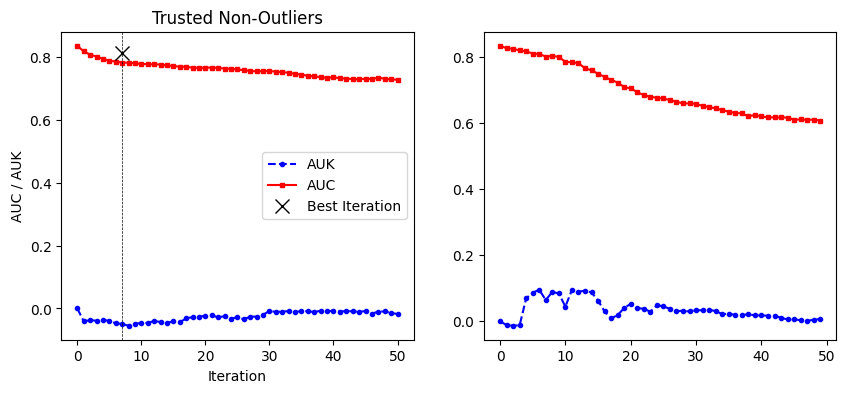

In [12]:
if args.train_tn:
    # Plot the AUC and kickout rate for each iteration of TN.
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    # Plot the AUC and kickout rate for each iteration of TN (ex)
    y_tn = np.arange(len(df_kick_ex.keys()))
    axs[0].plot(y_tn, df_kick_ex.mean(), color='blue', linestyle='--', marker='o', markersize=3, label='AUK')
    axs[0].plot(y_tn, df_auc_ex, color='red', linestyle='-', marker='s', markersize=3, label='AUC')
    axs[0].plot(output_ex, best_values_ex[0], color='black', linestyle='', marker='x', markersize=10, label='Best Iteration')
    axs[0].axvline(x=output_ex, color='black', linestyle='--', linewidth=0.5)
    axs[0].set_title('Trusted Non-Outliers')
    axs[0].set_xlabel('Iteration')
    axs[0].set_ylabel('AUC / AUK')
    axs[0].legend()

    # Plot the AUC and kickout rate for each iteration of TNplus (ls)
    y_plus = np.arange(len(df_kick_ls.keys()))
    axs[1].plot(y_plus, df_kick_ls.mean(), color='blue', linestyle='--', marker='o', markersize=3, label='AUK')
    axs[1].plot(y_plus, df_auc_ls, color='red', linestyle='-', marker='s', markersize=3, label='AUC')
    axs[1].plot(output_ls, best_values_ls[0], color='black', linestyle='', marker='x', markersize=10, label='Best Iteration')
    axs[1].axvline(x=output_ls, color='black', linestyle='--', linewidth=0.5)
    axs[1].set_title('Trusted Non-Outliers Plus')
    axs[1].set_xlabel('Iteration')
    axs[1].set_ylabel('AUC / AUK')
    axs[1].legend()

    if args.use_test:
        filename = Path(os.path.join(backup_image_folder, f'TN_AUC_AUK/test_{main_seed}_{args.percent_bad}.png'))
        filename.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(filename, metadata=metadata)
    else:
        filename = Path(os.path.join(backup_image_folder, f'TN_AUC_AUK/val_{main_seed}_{args.percent_bad}.png'))
        filename.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(filename, metadata=metadata)
    detailed_logger.debug(f'Image saved to {filename}')

    # Update the models dictionary with the best models for each technique

    models_dict.update({f'TN': models_ex[f'TN_{output_ex}']})
    models_dict.update({f'TN+': models_ls[f'TN_{output_ls}']})

else:
    detailed_logger.debug(f'No TN fitted')


../../backup/Images/ALL_AUC_AUK/val_302463_0.2.png


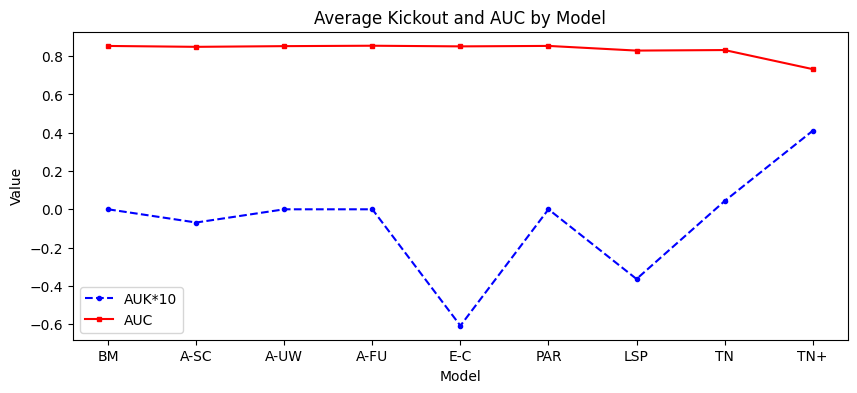

In [ ]:
# Evaluate the RI models
auk = ri.area_under_the_kick(models_dict, X_eval, y_eval, R_eval, low_AR, high_AR).mean().round(4)
metrics = ri.get_metrics_RI(models_dict, X_eval, y_eval, X_unl=R_eval).round(4)
metrics = metrics.drop(['Kickout', 'KG', 'KB'], axis=0)
metrics = pd.concat([metrics, auk.to_frame(name='AUK').T])
auc = metrics.loc['AUC', :].round(4)

detailed_logger.debug(f'AUC and AUK calculated')

fig, ax = plt.subplots(figsize=(10, 4))  # Create a figure and an axes.

# Plot the AUC and kickout rate for each model.
ax.plot(auk*10, color='blue', linestyle='--', marker='o', markersize=3, label='AUK*10')
ax.plot(auc, color='red', linestyle='-', marker='s', markersize=3, label='AUC')
ax.set_xlabel('Model')
ax.set_ylabel('Value')
ax.set_title('Average Kickout and AUC by Model')
ax.legend()

if args.use_test:
    filename = Path(os.path.join(backup_image_folder, f'ALL_AUC_AUK/test_{main_seed}_{args.percent_bad}.png'))
    filename.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(filename, metadata=metadata)
else:
    filename = Path(os.path.join(backup_image_folder, f'ALL_AUC_AUK/val_{main_seed}_{args.percent_bad}.png'))
    filename.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(filename, metadata=metadata)
    detailed_logger.debug(f'Image saved to {filename}')
print(filename)


# metrics['metadata'] = str(metadata)
if args.use_test:
    filepath = Path(os.path.join(ri_datasets_path, f'metrics_bm/test/Exp-{main_seed}-{year}.csv'))
else:
    filepath = Path(os.path.join(ri_datasets_path, f'metrics_bm/val/Exp-{main_seed}-{year}.csv'))
filepath.parent.mkdir(parents=True, exist_ok=True)
metrics.to_csv(filepath, index=True)

detailed_logger.debug(f'Metrics saved to {filepath}')


if args.train_tn:
    # Define the file path to save the results
    df_kick_ex['metadata'] = str(metadata)
    df_kick_ls['metadata'] = str(metadata)

    if args.use_test:
        filepath_ex = Path(os.path.join(ri_datasets_path,f'area_under_the_kick/test/ex_{main_seed}.csv'))
        filepath_ls = Path(os.path.join(ri_datasets_path,f'area_under_the_kick/test/ls_{main_seed}.csv'))
    else:
        filepath_ex = Path(os.path.join(ri_datasets_path,f'area_under_the_kick/val/ex_{main_seed}.csv'))
        filepath_ls = Path(os.path.join(ri_datasets_path,f'area_under_the_kick/val/ls_{main_seed}.csv'))
        
    # Save the results to a CSV file
    filepath_ex.parent.mkdir(parents=True, exist_ok=True)
    filepath_ls.parent.mkdir(parents=True, exist_ok=True)

    df_kick_ex.round(4).to_csv(filepath_ex, index=True)
    detailed_logger.debug(f'Kickout saved to {filepath_ex}')
    
    df_kick_ls.round(4).to_csv(filepath_ls, index=True)
    detailed_logger.debug(f'Kickout saved to {filepath_ls}')



In [ ]:
results = pd.concat([auk,auc], axis=1, keys=['AUK', 'AUC'])
results

,AUK,AUC
BM,0.0000,0.8531
A-SC,-0.0069,0.8485
A-UW,0.0000,0.8521
A-FU,0.0000,0.8543
E-C,-0.0608,0.8509
PAR,0.0000,0.8533
LSP,-0.0364,0.8289
TN,0.0043,0.8317
TN+,0.0410,0.7321
